In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from datasets import load_dataset
data = load_dataset("uoft-cs/cifar10")
data

d:\python workspace\Machine_Leaning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

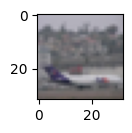

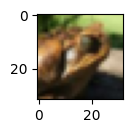

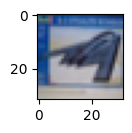

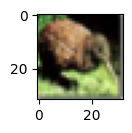

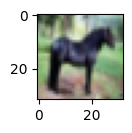

In [3]:

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(data['train']['img'][i])
    plt.show()

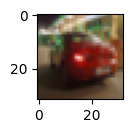

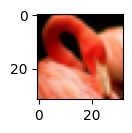

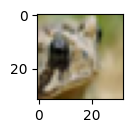

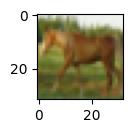

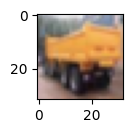

In [4]:
train_data = data['train']
test_data = data['test']
# Shuffling the training data to make sure the model does not learn the order of the data
train_data = train_data.shuffle(seed=42)
train_data = train_data[:]
test_data = test_data[:]
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data['img'][i])
    plt.show()


In [5]:
# Converting the PIL type images to tensors

from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
# Checking the length of the training data so I can loop through it and transofrm every PIL image to a tensor whic helps me to train the model
print(len(train_data['img']))
for i in range(len(train_data['img'])):
    train_data['img'][i] = transform(train_data['img'][i])
for i in range(len(test_data['img'])):
    test_data['img'][i] = transform(test_data['img'][i])

50000


In [6]:
# Cross checking if the images is converted to tensors or not
print(train_data['img'][:5])
train_data['label'][:5]

[tensor([[[0.1255, 0.1255, 0.1294,  ..., 0.8039, 0.6196, 0.6471],
         [0.1333, 0.1451, 0.1451,  ..., 0.7843, 0.6039, 0.6078],
         [0.1529, 0.1608, 0.1608,  ..., 0.6980, 0.5725, 0.5569],
         ...,
         [0.2275, 0.2275, 0.2275,  ..., 0.4863, 0.5059, 0.5333],
         [0.2275, 0.2275, 0.2314,  ..., 0.4863, 0.5020, 0.5216],
         [0.2275, 0.2235, 0.2353,  ..., 0.4863, 0.4941, 0.5098]],

        [[0.1098, 0.0980, 0.0941,  ..., 0.6824, 0.5529, 0.5765],
         [0.1255, 0.1137, 0.1098,  ..., 0.6392, 0.5373, 0.5529],
         [0.1412, 0.1255, 0.1216,  ..., 0.5647, 0.4941, 0.5020],
         ...,
         [0.1804, 0.1765, 0.1765,  ..., 0.4039, 0.4235, 0.4471],
         [0.1804, 0.1804, 0.1765,  ..., 0.4039, 0.4196, 0.4392],
         [0.1765, 0.1725, 0.1804,  ..., 0.4000, 0.4157, 0.4275]],

        [[0.0980, 0.1059, 0.1137,  ..., 0.4471, 0.2902, 0.3333],
         [0.1098, 0.1216, 0.1294,  ..., 0.3765, 0.2706, 0.2941],
         [0.1294, 0.1373, 0.1412,  ..., 0.2980, 0.2471, 0

[1, 2, 6, 7, 9]

In [7]:
# As now i have all the input data in the form of tensors, I will now convert the labels to tensors as well
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()
train_data_copy['label'] = torch.nn.functional.one_hot(torch.tensor(train_data_copy['label'], dtype=torch.long), num_classes=10).float()
test_data_copy['label'] = torch.nn.functional.one_hot(torch.tensor(test_data_copy['label'],dtype = torch.long), num_classes=10).float()
print(train_data['label'][:5])

[1, 2, 6, 7, 9]


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(train_data['img'][0].shape) # Need to check the shape to calculate dimensions for other formulas

torch.Size([3, 32, 32])


# Defining the model

In [9]:
# Input data is ready to be fed to the model
# Now I will create a model

class BeautifulModel(torch.nn.Module):
    def __init__(self):
        super(BeautifulModel, self).__init__()
        self.layer1 = torch.nn.Conv2d(3, 6, 5)
        self.dropout1 = torch.nn.Dropout(p=0.5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.layer2 = torch.nn.Conv2d(6, 16, 5)
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.connecting_layer = torch.nn.Linear(16 * 5 * 5, 120)
        self.connecting_layer2 = torch.nn.Linear(120, 84)
        self.output_layer = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.layer1(x)))
        x = self.pool(torch.nn.functional.relu(self.layer2(x)))
        x = x.view(-1, 16
                   * 5 * 5)
        x = self.dropout1(x)
        x = torch.nn.functional.relu(self.connecting_layer(x))
        x = self.dropout1(x)
        x = torch.nn.functional.relu(self.connecting_layer2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x
    

In [10]:
model = BeautifulModel().to(device)
model

BeautifulModel(
  (layer1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout(p=0.5, inplace=False)
  (connecting_layer): Linear(in_features=400, out_features=120, bias=True)
  (connecting_layer2): Linear(in_features=120, out_features=84, bias=True)
  (output_layer): Linear(in_features=84, out_features=10, bias=True)
)

# Running the model

In [30]:
from sklearn.metrics import accuracy_score, f1_score
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
batch_size = 32
epochs = 35
train_loss = list()
test_loss = list()
train_accuracy = list()
for epoch in range(epochs):
    model.train()
    accuracy=0
    for i in range(0,len(train_data['img']),batch_size):
        inputs = train_data_copy['img'][i:i+batch_size]
        labels = train_data_copy['label'][i:i+batch_size]
        labelIndexes = train_data['label'][i:i+batch_size]
        label = torch.tensor(labelIndexes).to(device)
        
        # Insuring that the input and labels are tensors
        inputs = torch.stack(inputs).to(device)
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss_val = criterion(outputs, labels)
        train_loss_val.backward()
        optimizer.step()
        output = torch.argmax(outputs, dim=1)
        accuracy+=(output == label).sum().item()
    accuracy = accuracy/len(train_data['img'])
        
    train_loss.append(train_loss_val.item())
    print('Training progress')
    print(f'Epoch {epoch+1}, Loss: {train_loss_val.item()}, accuracy: {accuracy*100}')
    train_accuracy.append(accuracy)
    model.eval()
    with torch.inference_mode():
        test_inputs = test_data['img']
        test_labels = test_data_copy['label']
        test_inputs = torch.stack(test_inputs).to(device)
        test_labels = torch.tensor(test_labels).to(device)
        test_output = model(test_inputs)
        test_loss_val = criterion(test_output, test_labels)
        test_loss.append(test_loss_val.item())
        output = torch.argmax(test_output, dim=1)
        print(output[:5], test_data['label'][:5])
        test_acc = 0
        for i in range(len(test_data['img'])):
            if output[i] == test_data['label'][i]:
                test_acc += 1
        test_acc = test_acc/len(test_data['img'])
        f1 = f1_score(torch.argmax(test_output, dim=1), test_data['label'], average='weighted')
        print(f'Epoch {epoch+1}, Test Loss: {test_loss_val.item()}, accuracy: {100*test_acc}, f1 score: {f1}')
print('Model has learned its stuff')

C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 1, Loss: 1.171879768371582, accuracy: 54.106


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 1, Test Loss: 1.1272175312042236, accuracy: 60.45, f1 score: 0.6075048419063758


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 2, Loss: 1.2050085067749023, accuracy: 53.898


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 2, Test Loss: 1.1360276937484741, accuracy: 60.3, f1 score: 0.6042601675260793


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 3, Loss: 1.0493525266647339, accuracy: 54.379999999999995


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 3, Test Loss: 1.1472893953323364, accuracy: 59.3, f1 score: 0.5973702385074375


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 4, Loss: 1.0227092504501343, accuracy: 54.262


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 4, Test Loss: 1.1178456544876099, accuracy: 60.809999999999995, f1 score: 0.6142292288280661


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 5, Loss: 1.398158311843872, accuracy: 54.422000000000004


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 5, Test Loss: 1.1265869140625, accuracy: 60.11, f1 score: 0.605106911358895


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 6, Loss: 1.0599524974822998, accuracy: 54.504


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 6, Test Loss: 1.1174815893173218, accuracy: 60.74, f1 score: 0.6103759882374611


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 7, Loss: 1.1943552494049072, accuracy: 54.674


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 7, Test Loss: 1.1198090314865112, accuracy: 61.029999999999994, f1 score: 0.6097905861299303


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 8, Loss: 1.103910207748413, accuracy: 54.394


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 8, Test Loss: 1.1312381029129028, accuracy: 60.45, f1 score: 0.6052756025647197


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 9, Loss: 1.1587860584259033, accuracy: 54.645999999999994


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 3]) [3, 8, 8, 0, 6]
Epoch 9, Test Loss: 1.1357920169830322, accuracy: 59.650000000000006, f1 score: 0.5980988127932727


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 10, Loss: 1.0551797151565552, accuracy: 55.21


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 4]) [3, 8, 8, 0, 6]
Epoch 10, Test Loss: 1.1386172771453857, accuracy: 59.77, f1 score: 0.5968271160616657


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 11, Loss: 1.1851038932800293, accuracy: 54.900000000000006


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 11, Test Loss: 1.0995457172393799, accuracy: 61.919999999999995, f1 score: 0.6212665581011809


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 12, Loss: 0.92731773853302, accuracy: 55.006


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 12, Test Loss: 1.1155049800872803, accuracy: 60.62, f1 score: 0.6085848979233275


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 13, Loss: 1.0260676145553589, accuracy: 54.87


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 4]) [3, 8, 8, 0, 6]
Epoch 13, Test Loss: 1.1224168539047241, accuracy: 61.14000000000001, f1 score: 0.6097487592727264


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 14, Loss: 1.3369948863983154, accuracy: 54.81399999999999


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 14, Test Loss: 1.0962116718292236, accuracy: 61.82, f1 score: 0.6227784866164376


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 15, Loss: 1.1839913129806519, accuracy: 54.908


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 15, Test Loss: 1.099440097808838, accuracy: 61.59, f1 score: 0.6163915821590946


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 16, Loss: 1.2936763763427734, accuracy: 54.94799999999999


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 16, Test Loss: 1.0850558280944824, accuracy: 62.519999999999996, f1 score: 0.6281874309065417


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 17, Loss: 1.1552228927612305, accuracy: 54.998000000000005


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 0, 3]) [3, 8, 8, 0, 6]
Epoch 17, Test Loss: 1.1675060987472534, accuracy: 58.95, f1 score: 0.5857725626546386


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 18, Loss: 1.3421099185943604, accuracy: 55.208


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 4]) [3, 8, 8, 0, 6]
Epoch 18, Test Loss: 1.1104480028152466, accuracy: 61.19, f1 score: 0.6116063349329058


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 19, Loss: 1.2448911666870117, accuracy: 55.152


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 19, Test Loss: 1.1021159887313843, accuracy: 61.519999999999996, f1 score: 0.617153524428008


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 20, Loss: 1.0274829864501953, accuracy: 55.35


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 3]) [3, 8, 8, 0, 6]
Epoch 20, Test Loss: 1.0947237014770508, accuracy: 61.68, f1 score: 0.6172692889110685


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 21, Loss: 0.8197497129440308, accuracy: 55.467999999999996


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 21, Test Loss: 1.1039462089538574, accuracy: 61.36000000000001, f1 score: 0.6132048165560623


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 22, Loss: 1.1639628410339355, accuracy: 55.588


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 3]) [3, 8, 8, 0, 6]
Epoch 22, Test Loss: 1.1012051105499268, accuracy: 61.150000000000006, f1 score: 0.6119223853010596


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 23, Loss: 1.0286953449249268, accuracy: 55.324


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 23, Test Loss: 1.091491460800171, accuracy: 62.68, f1 score: 0.62716586796074


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 24, Loss: 1.1550745964050293, accuracy: 55.53399999999999


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 24, Test Loss: 1.1009111404418945, accuracy: 61.29, f1 score: 0.6136167030770958


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 25, Loss: 1.1021153926849365, accuracy: 55.57


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 25, Test Loss: 1.1051384210586548, accuracy: 61.019999999999996, f1 score: 0.611369126417116


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 26, Loss: 1.363945484161377, accuracy: 55.833999999999996


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 26, Test Loss: 1.0902119874954224, accuracy: 62.339999999999996, f1 score: 0.6231810831776547


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 27, Loss: 1.026093602180481, accuracy: 55.898


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 27, Test Loss: 1.0802606344223022, accuracy: 62.69, f1 score: 0.6292982226052758


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 28, Loss: 1.0591864585876465, accuracy: 55.513999999999996


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 28, Test Loss: 1.0985623598098755, accuracy: 61.839999999999996, f1 score: 0.6164467308345651


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 29, Loss: 0.9912214279174805, accuracy: 55.736


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 29, Test Loss: 1.0902161598205566, accuracy: 61.61, f1 score: 0.6195306559804175


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 30, Loss: 1.0199253559112549, accuracy: 55.83


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 30, Test Loss: 1.0811097621917725, accuracy: 62.36000000000001, f1 score: 0.6250119589660416


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 31, Loss: 1.229642629623413, accuracy: 55.952


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 8, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 31, Test Loss: 1.0766820907592773, accuracy: 62.45, f1 score: 0.6264452008487942


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 32, Loss: 1.1235381364822388, accuracy: 55.848


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 32, Test Loss: 1.092651128768921, accuracy: 61.42999999999999, f1 score: 0.6188342302116239


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 33, Loss: 1.226848840713501, accuracy: 56.092


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 33, Test Loss: 1.0761494636535645, accuracy: 62.12, f1 score: 0.6232202660799784


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 34, Loss: 1.1681432723999023, accuracy: 55.922000000000004


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 8, 6]) [3, 8, 8, 0, 6]
Epoch 34, Test Loss: 1.1057401895523071, accuracy: 60.86, f1 score: 0.6080930011488507


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Training progress
Epoch 35, Loss: 1.1214663982391357, accuracy: 56.076


C:\Users\anshp\AppData\Local\Temp\ipykernel_14376\1874186427.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)


tensor([3, 1, 8, 0, 6]) [3, 8, 8, 0, 6]
Epoch 35, Test Loss: 1.088144302368164, accuracy: 62.38, f1 score: 0.6225868870955952
Model has learned its stuff


### Plotting Stuff


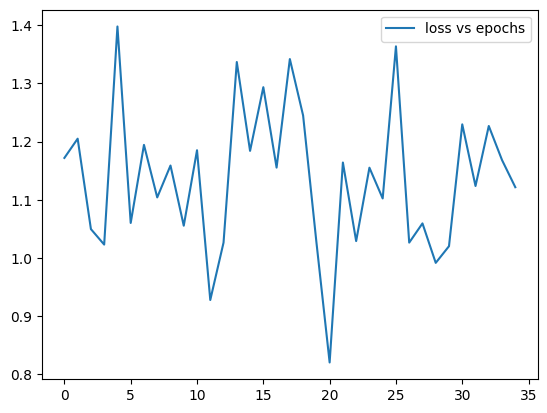

In [31]:

plt.plot(range(epochs),train_loss, label='loss vs epochs')
plt.legend()
plt.show()

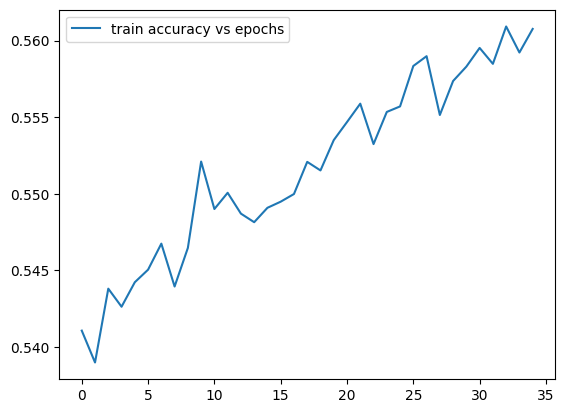

In [32]:
plt.plot(range(epochs),train_accuracy, label='train accuracy vs epochs')
plt.legend()
plt.show()

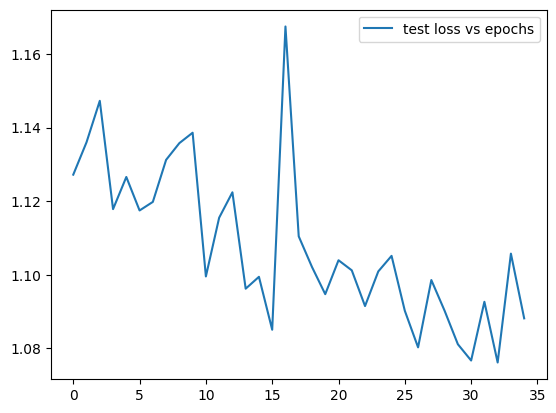

In [33]:

plt.plot(range(epochs),test_loss,  label='test loss vs epochs')
plt.legend()
plt.show()

In [34]:
torch.save(model, 'model.pth')